<a href="https://colab.research.google.com/github/JeevanLokanathTivo/MovieGenre/blob/master/GenreDetectionv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
import pandas
import numpy as np

Check FastAI library version


In [39]:
import fastai; fastai.__version__

'1.0.52'

Download the poster dataset and uncompress it 



In [0]:
#!wget https://storage.googleapis.com/kaggle-forum-message-attachments/197363/6743/posters.7z

In [0]:
#!apt-get install p7zip-full
#!p7zip -d posters.7z

^C
/usr/bin/p7zip: cannot read posters.7z


There are around 848 zero bytes poster files, do clean up by removing these files and corresponding genre

In [3]:
#This data source has 848 zero bytes poster files
#remove these files and corresponding genre
!find "./posters" -size 0 -print | tail

./posters/97109.jpg
./posters/972385.jpg
./posters/97607.jpg
./posters/977611.jpg
./posters/979953.jpg
./posters/98208.jpg
./posters/982851.jpg
./posters/98343.jpg
./posters/98624.jpg
./posters/996957.jpg


In [0]:
zero_files = !find "./posters" -size 0 -print | cut -d'/' -f3 | cut -d'.' -f1

In [5]:
zero_files[:5]

['1002581', '1010054', '1013528', '1013746', '102336']

Get the poster-genere.csv file 

In [0]:
#!rm -rf MovieGenre
!git clone https://github.com/vinpBlr/MovieGenre.git

Cloning into 'MovieGenre'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 5), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
!ls

MovieGenre  posters  sample_data  tmp


In [0]:
poster_genre = pd.read_csv('MovieGenre/poster_genre.csv')

In [8]:
poster_genre.sample(4)

,image_name,tags
30649,70641,Drama|Thriller
22289,181315,Fantasy|Horror
17770,96841,Drama
29635,3323314,Biography


Remove all zero byte size files from the poster-genre lookup

In [9]:
#remove zero byte files from csv
valid_poster_genre = poster_genre[~poster_genre['image_name'].isin(zero_files)]
valid_poster_genre.shape

(39140, 2)

In [0]:
valid_poster_genre.to_csv('valid_poster_genre.csv', index=False)

In [0]:
#works
#np.random.seed(44)
#databch = (ImageList.from_csv(path='./',csv_name='MovieGenre/poster_genre.csv',folder='posters',suffix='.jpg')
#          .use_partial_data(0.3)
#          .split_by_rand_pct(0.2)
#          )
#databch = databch.label_from_df(cols='tags', label_delim="|")

Create Databunch with default transformation, use 30% of data for training and split 80:20 train to test data

In [0]:
#works
np.random.seed(44)
databch = (ImageList.from_csv(path='/content',csv_name='valid_poster_genre.csv',folder='posters',suffix='.jpg')
          .use_partial_data(0.3)
          .split_by_rand_pct(0.2)
          )
databch = databch.label_from_df(cols='tags', label_delim="|")

In [0]:
data = databch.transform(get_transforms(),size=128).databunch().normalize(imagenet_stats)

Check the possible genres

In [24]:
print(data.c)
data.classes

27


['Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

Visualize few posters and its genre

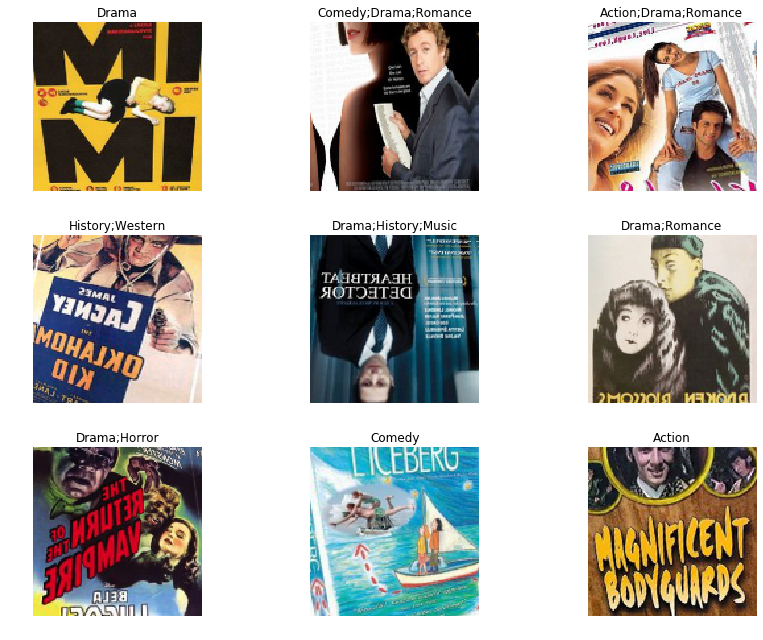

In [14]:
data.show_batch(3, figsize=(12,9))

Use accuracy with 30% threshold and f-beta as error metric to train the resnet 34 model

In [0]:

acc_02 = partial(accuracy_thresh, thresh = 0.3)
f_score = partial(fbeta, thresh = 0.2)


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score], model_dir="tmp/models")


In [17]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.385306,0.214342,0.917692,0.463650,00:47
1,0.224381,0.206628,0.918575,0.488765,00:47
2,0.208877,0.203536,0.918165,0.498108,00:47
3,0.203213,0.202512,0.918780,0.502920,00:47


In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

One more cycle training

In [26]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.208812,0.208168,0.914380,0.497447,00:47
1,0.208096,0.202828,0.921336,0.484666,00:46
2,0.203358,0.201558,0.919443,0.505753,00:47
3,0.198185,0.198471,0.918055,0.525182,00:49
4,0.194166,0.197276,0.919648,0.520783,00:46


Cross check model's predicting capability

In [28]:
img = learn.data.train_ds[0][0]
learn.predict(img)

(MultiCategory Drama;Romance,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([3.0609e-02, 3.2054e-05, 4.9994e-02, 2.9655e-03, 6.1722e-02, 3.1353e-01,
         9.1798e-02, 1.3074e-02, 8.1705e-01, 4.3958e-02, 2.6118e-02, 6.3740e-03,
         3.3941e-02, 1.0630e-02, 2.3303e-02, 1.6918e-02, 5.6725e-02, 2.4177e-04,
         3.5524e-05, 5.7443e-01, 8.1928e-03, 6.3692e-03, 1.0962e-02, 4.5324e-05,
         5.8203e-02, 1.1245e-02, 8.2052e-03]))

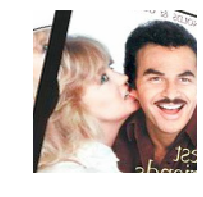

In [30]:
learn.data.train_ds[0][0].show()

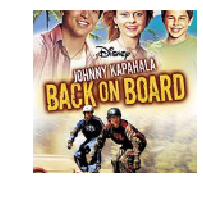

In [41]:
learn.data.valid_ds[0][0].show()

In [40]:
img = learn.data.valid_ds[0][0]
learn.predict(img)

(MultiCategory Comedy,
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1.4142e-01, 1.5010e-04, 1.3520e-01, 1.1389e-02, 2.9483e-02, 6.9829e-01,
         1.6340e-01, 1.7735e-02, 3.6140e-01, 7.2134e-02, 4.1842e-02, 2.5385e-02,
         1.4011e-02, 1.9720e-02, 2.1584e-02, 2.2864e-02, 1.8822e-02, 4.9022e-04,
         1.2800e-04, 2.0117e-01, 2.0242e-02, 2.6677e-03, 5.3174e-02, 5.1249e-05,
         3.2872e-02, 2.2573e-02, 5.7924e-02]))

Check how well model is doing on validataion set 

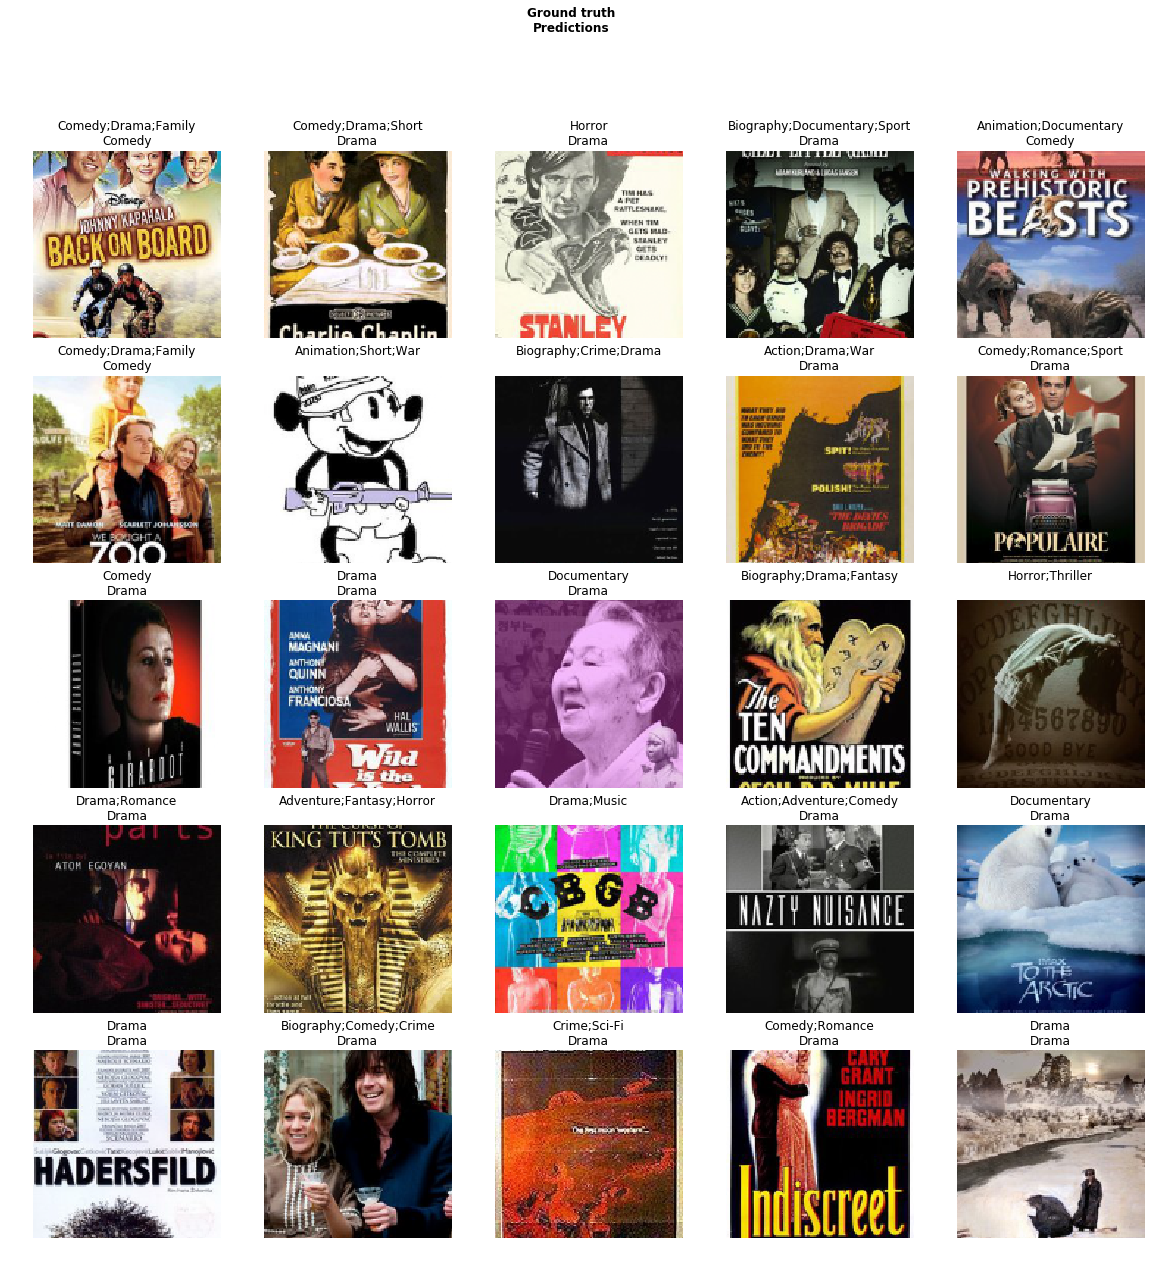

In [42]:
learn.show_results(ds_type=DatasetType.Valid, rows = 5)